[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alexj-smolin/ds-school/blob/main/part4/HW2.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# архитектура модели
# гиперпараметры
# загрузчик данных
# формирование батча
# инициализировать модель
# оптимизатор
# функция потерь
# опционально шедулеры
# трейн луп

In [3]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)


In [5]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

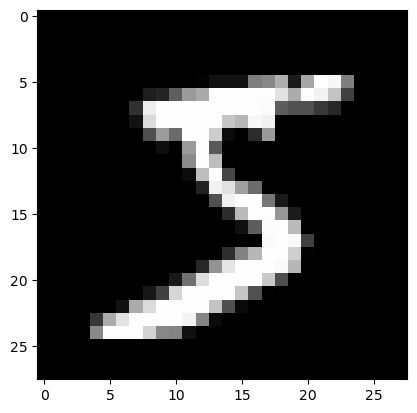

In [6]:
plt.imshow(dataset_train.data[0].detach().numpy(), cmap='gray')
plt.show()

In [7]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom init nn.init.xavier_uniform(self.linear1.weight) 
        self.do = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.do(x)
        x = self.linear2(x)

        return x


In [8]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset
dataset = datasets.MNIST('.', train=True, download=True)
test_dataset = datasets.MNIST('.', train=False, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [9]:
dataloader = DataLoader(dataset, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size, 
                             collate_fn=collate_fn)

In [10]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [11]:
60000 // 128 # число шагов

468

In [12]:
for epoch in range(n_epochs):
    model.train()
    running_acc = 0.
    running_loss = 0.
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        running_acc += (predict.argmax(dim=1) == batch['target']).float().mean().item()
        running_loss += loss.item()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}, accuracy: {running_acc / (i + 1)}')
    print(f'epoch: {epoch}, train all, loss: {running_loss / len(dataloader)}, '
          f'accuracy: {running_acc / len(dataloader)}'
         )

    # TODO Добавить тест модели на тестовом датасете
    model.eval()
    test_sum_acc = 0.
    test_obj_cnt = 0
    test_run_loss = 0.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            predict = model(batch['data'].to(device))
            loss = loss_func(predict, batch['target'].to(device))
            test_sum_acc += (predict.argmax(dim=1) == batch['target']).float().sum().item()
            test_obj_cnt += len(batch['target'])
            test_run_loss += loss.item()
    print(f'epoch: {epoch}, test all, loss: {test_run_loss / len(test_dataloader)}, '
          f'accuracy: {test_sum_acc / test_obj_cnt}'
         )
    print('-' * 64)
            
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.305351495742798, accuracy: 0.1171875
epoch: 0, step: 200, loss: 0.17679888010025024, accuracy: 0.8602300995024875
epoch: 0, step: 400, loss: 0.19542142748832703, accuracy: 0.892339463840399
epoch: 0, train all, loss: 0.37277921015380794, accuracy: 0.8989049145299145
epoch: 0, test all, loss: 0.19122454350154044, accuracy: 0.9428
----------------------------------------------------------------
epoch: 1, step: 0, loss: 0.11898361146450043, accuracy: 0.9453125
epoch: 1, step: 200, loss: 0.13845784962177277, accuracy: 0.9479166666666666
epoch: 1, step: 400, loss: 0.11531732231378555, accuracy: 0.9507870947630923
epoch: 1, train all, loss: 0.1658768204367186, accuracy: 0.9515391292735043
epoch: 1, test all, loss: 0.12691658613554946, accuracy: 0.9632
----------------------------------------------------------------
epoch: 2, step: 0, loss: 0.16985543072223663, accuracy: 0.9609375
epoch: 2, step: 200, loss: 0.10970215499401093, accuracy: 0.962997512437811
epoch: 2, 

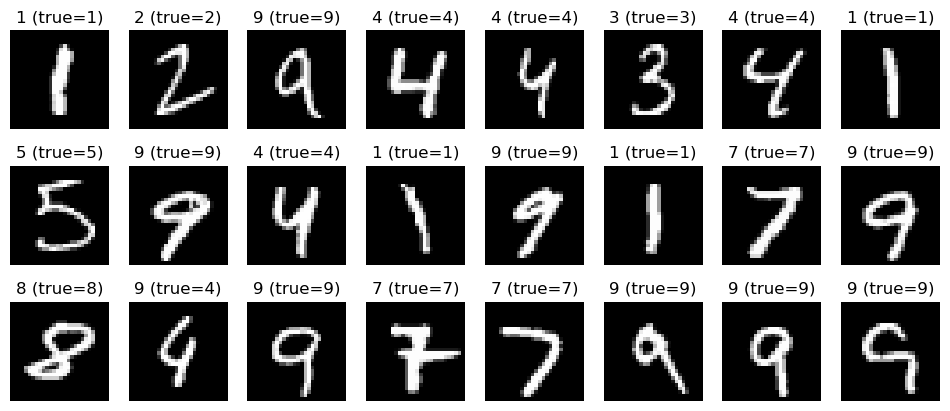

In [13]:
# предсказания на тестовом датасете

plt.figure(figsize=(12, 5))

val_batch = next(iter(test_dataloader))
count = 24
idx = torch.randperm(len(val_batch['target']))[:count]
val_imgs = val_batch['data'][idx]
val_predicts = model(val_imgs).argmax(1)
val_labels = val_batch['target'][idx]
for i, img in enumerate(val_imgs):
    ax = plt.subplot(3, 8, i + 1)
    ax.set(title=f'{val_predicts[i].item()} (true={val_labels[i].item()})')
    plt.imshow(img.numpy().reshape(28, -1), cmap='gray')
    plt.axis('off')

# Новый раздел

In [14]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device='mps' # запускалось на apple m1
# device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [15]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        # TODO добавить батч норм
        self.bn = nn.BatchNorm2d(output_ch)
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):

        return self.do(self.bn(self.conv(x)))

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза
        # TODO еще уменьшить размер фичматрицы
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 4, 2, 1) # 14x14 -> 7x7
        # TODO увеличить число выходных каналов
        self.conv3 = ConvDO(hidden_ch, 10, 3, 1, 1)
        self.linear = nn.Linear(
            10 * 7 * 7, # TODO поправить при изменении числа каналов и размера фич матриц
            output_dim,
        )  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [16]:
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [17]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [18]:
for epoch in range(n_epochs):
    model_conv.train()
    running_acc = 0.
    running_loss = 0.
    for i, (inputs, labels) in enumerate(trainloader):
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()

        running_acc += (predict.argmax(dim=1).detach().cpu() == labels).float().mean().item()
        running_loss += loss.item()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}, accuracy: {running_acc / (i + 1)}')
    print(f'epoch: {epoch}, train all, loss: {running_loss / len(trainloader)}, '
          f'accuracy: {running_acc / len(trainloader)}'
         )

    model_conv.eval()
    test_sum_acc = 0.
    test_obj_cnt = 0
    test_run_loss = 0.
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            predict = model_conv(inputs.to(device))
            loss = loss_func(predict, labels.to(device))
            test_sum_acc += (predict.argmax(dim=1).detach().cpu() == labels).float().sum().item()
            test_obj_cnt += len(labels)
            test_run_loss += loss.item()
    print(f'epoch: {epoch}, test all, loss: {test_run_loss / len(testloader)}, '
          f'accuracy: {test_sum_acc / test_obj_cnt}'
         )
    print('-' * 64)
    
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3763513565063477, accuracy: 0.0859375
epoch: 0, step: 200, loss: 0.18362456560134888, accuracy: 0.921836131840796
epoch: 0, step: 400, loss: 0.09735096991062164, accuracy: 0.9492479738154613
epoch: 0, train all, loss: 0.19238125971064735, accuracy: 0.9535924145299145
epoch: 0, test all, loss: 0.04544302095205356, accuracy: 0.987479967948718
----------------------------------------------------------------
epoch: 1, step: 0, loss: 0.0635443776845932, accuracy: 0.9765625
epoch: 1, step: 200, loss: 0.08765792101621628, accuracy: 0.9836753731343284
epoch: 1, step: 400, loss: 0.03967823460698128, accuracy: 0.9842581047381546
epoch: 1, train all, loss: 0.0527046758066624, accuracy: 0.9845085470085471
epoch: 1, test all, loss: 0.036617674333497115, accuracy: 0.9894831730769231
----------------------------------------------------------------
epoch: 2, step: 0, loss: 0.03229110687971115, accuracy: 0.984375
epoch: 2, step: 200, loss: 0.01788051426410675, accuracy: 0.988

Выводы:
* Замена полносвязных слоев на 2D свертки + BatchNorm улучшили качество модели (на тесте accuracy ~99% вместо 98%) на последней итерации